In [2]:
from seg.segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import matplotlib.pyplot as plt
sam = sam_model_registry["default"](checkpoint="./seg/model/sam_vit_h_4b8939.pth")
mask_generator = SamAutomaticMaskGenerator(sam)
mask_generator.predictor.model.cuda()
# predictor = SamPredictor(sam)
# predictor.model.cuda()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [3]:
# CPU: 86.40612578392029s
# GPU: 6.959840774536133
import cv2
from PIL import Image
import torch
image = cv2.imread(r'./data/data/class2/train/20220106091837[2]_33.jpg')
import time
t1 = time.time()
masks = mask_generator.generate(image)
t2 = time.time()
print(t2 - t1)
print(torch.cuda.max_memory_allocated() / 1024 / 1024 / 1024)


5.737271308898926
6.920134544372559


In [7]:
from utils import *

res = get_anns(masks)

if res[2]['bbox'][0] < res[3]['bbox'][0]:
    off1 = res[0]['bbox'][0] - res[2]['bbox'][0]
    off2 = res[3]['bbox'][0] + res[3]['bbox'][2] - res[0]['bbox'][0] + res[0]['bbox'][2]
else:
    off1 = res[0]['bbox'][0] - res[3]['bbox'][0]
    off2 = res[2]['bbox'][0] + res[2]['bbox'][2] - res[0]['bbox'][0] + res[0]['bbox'][2]

offset = abs(off2 - off1)
offset_rate = offset / ((off1 + off2) / 2)

TypeError: 'NoneType' object is not subscriptable

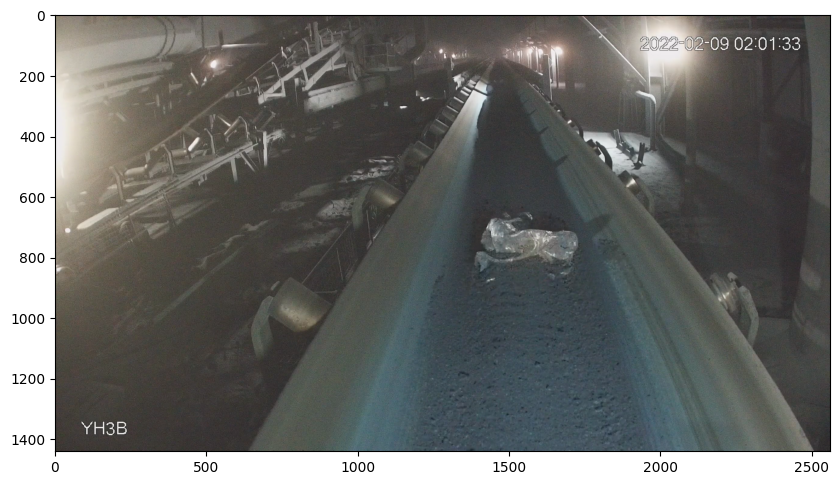

In [ ]:
import numpy as np
predictor.set_image(image)
input_point = np.array([[1280, 1080]])
input_label = np.array([1])
masks, scores, logits  = predictor.predict(point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

type(masks)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show() 

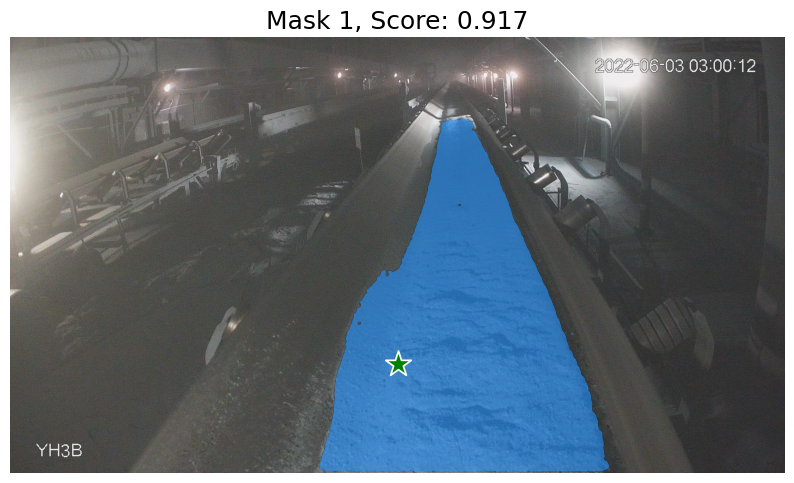

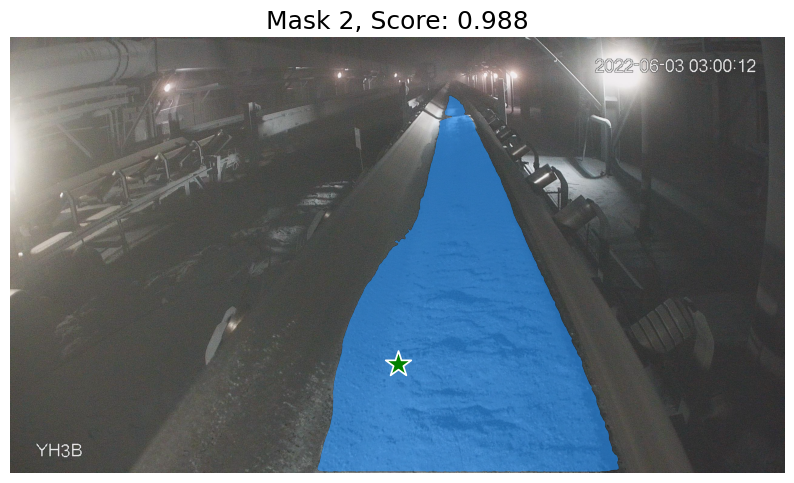

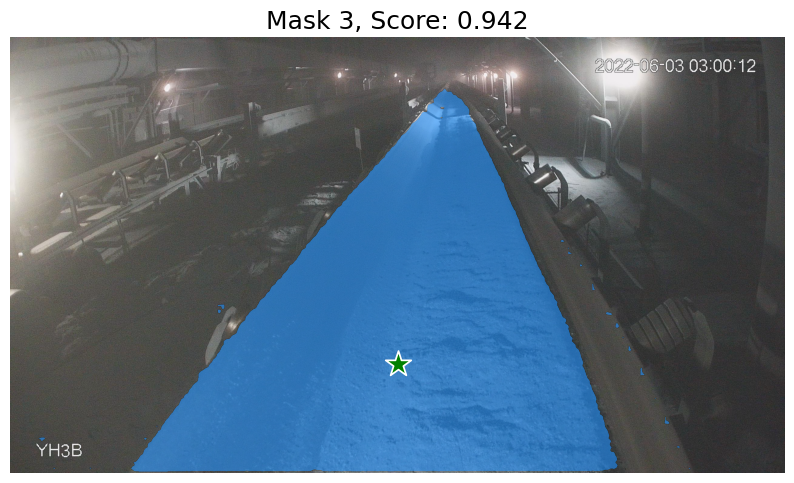

In [41]:


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

In [7]:
len(masks)
masks[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

        Y        X    C
image[0:2560, 0:1440, :]

bbox: [X, Y, W, H]

In [7]:
import copy
# 获取最大和次大的mask,分别表示传送带和物料带
def get_max_mask(masks):
    max_area = [0, 0]
    next_area = [0, 0]
    left_area = [0, 0]
    right_area = [0, 0]
    for i, m in enumerate(masks):
        area = m['bbox'][2] * m['bbox'][3]
        # 分割结果需要在图像中间部分，不可过大，且不可过半
        if m['bbox'][0] > m['crop_box'][2] / 20 and m['bbox'][0] + m['bbox'][2] > m['crop_box'][2] / 2:
            if area > next_area[1]:
                if area > max_area[1]:
                    next_area = copy.deepcopy(max_area)
                    max_area[0] = i
                    max_area[1] = area
                else:
                    next_area[0] = i
                    next_area[1] = area
        # 分割效果不佳，手动处理，取左右两边与中间部分比较计算偏移
        if m['bbox'][3] > m['crop_box'][3] * 0.8:
            # 左边
            if m['bbox'][0] < m['crop_box'][2] / 2:
                if area < left_area[1]:
                    left_area[0] = i
                    left_area[1] = area
            # 右边
            else:
                if area < right_area[1]:
                    right_area[0] = i
                    right_area[1] = area

    print(f'indexs: {max_area[0], next_area[0], left_area[0], right_area[0]}')
    return masks[max_area[0]], masks[next_area[0]], masks[left_area[0]], masks[right_area[0]]

# 计算两端偏移像素差值和比例
def get_offset_diff(max_mask, next_mask, left_mask, right_mask):
    offset1 = next_mask['bbox'][0] - max_mask['bbox'][0]
    offset2 = max_mask['bbox'][0] + max_mask['bbox'][2] - next_mask['bbox'][0] - next_mask['bbox'][2]

    abs_off_diff = abs(offset1 - offset2)
    off_diff_rate = abs_off_diff / (offset1 + offset2) * 2

    print(f'1st: {offset1, offset2, abs_off_diff, off_diff_rate}')

    if off_diff_rate > 0.2:
        offset1 = next_mask['bbox'][0] - left_mask['bbox'][0]
        offset2 = right_mask['bbox'][0] + right_mask['bbox'][2] - next_mask['bbox'][0] - next_mask['bbox'][2]
    
        abs_off_diff = abs(offset1 - offset2)
        off_diff_rate = abs_off_diff / (offset1 + offset2) * 2
        print(f'2nd: {offset1, offset2, abs_off_diff, off_diff_rate}')

    return abs_off_diff, off_diff_rate

# 判断是否偏移
def judge_offset(masks):
    max_mask, next_mask, left_mask, right_mask = get_max_mask(masks)    
    return get_offset_diff(max_mask, next_mask, left_mask, right_mask)

abs_off_diff, off_diff_rate = judge_offset(masks)
print(abs_off_diff, off_diff_rate)


indexs: (2, 10, 0, 0)
1st: (983, -342, 1325, 4.134165366614664)
2nd: (555, -919, 1474, -8.098901098901099)
1474 -8.098901098901099


In [9]:
# 分割结果需要在图像中间部分，且不可过半
import copy
cv2.imwrite(f'./seg/test/ori.png', image)
max_area = [0, 0]
next_area = [0, 0]
for i, m in enumerate(masks):
    cv2.imwrite(f'./seg/test/{i}.png', image[m['bbox'][1]: m['bbox'][1] + m['bbox'][3], m['bbox'][0]:m['bbox'][0] + m['bbox'][2], :])
    if m['bbox'][0] > m['crop_box'][2] / 10 and m['bbox'][0] + m['bbox'][2] > m['crop_box'][2] / 2:
        area = m['bbox'][2] * m['bbox'][3]
        if area > next_area[1]:
            if area > max_area[1]:
                next_area = copy.deepcopy(max_area)
                max_area[0] = i
                max_area[1] = area
            else:
                next_area[0] = i
                next_area[1] = area
print(max_area)
print(next_area)
    

print(masks[max_area[0]]['bbox'])
print(masks[next_area[0]]['bbox'])
print(masks[next_area[0]]['crop_box'])


[3, 1131117]
[0, 769824]
[839, 540, 1261, 897]
[1034, 546, 864, 891]
[0, 0, 2560, 1440]


In [16]:
max_mask, next_mask = masks[max_area[0]], masks[next_area[0]]
offset1 = next_mask['bbox'][0] - max_mask['bbox'][0]
offset2 = max_mask['bbox'][0] + max_mask['bbox'][2] - next_mask['bbox'][0] - next_mask['bbox'][2]

abs_off_diff = abs(offset1 - offset2)
off_diff_rate = abs_off_diff / (offset1 + offset2) * 2
print(max_mask['bbox'])
print(next_mask['bbox'])
print(offset1, offset2, abs_off_diff, off_diff_rate)
print(masks[1]['bbox'], masks[2]['bbox'])

[310, 0, 2188, 1437]
[813, 7, 1365, 1429]
503 320 183 0.44471445929526127
[1688, 0, 811, 1436] [380, 0, 955, 1436]


In [1]:
import pandas as pd
t0 = pd.read_csv('../type0diff.csv')
t3 = pd.read_csv('../type3diff.csv')


In [2]:
t0.describe()

Unnamed: 0            1           2
count  198.000000   198.000000  198.000000
mean    98.500000   392.530303    2.127803
std     57.301832   449.817681    9.654303
min      0.000000     5.000000  -53.707317
25%     49.250000    73.000000    0.170321
50%     98.500000   171.000000    0.435013
75%    147.750000   648.750000    2.000000
max    197.000000  1918.000000   97.090909

In [3]:
t3.describe()

Unnamed: 0            1           2
count   164.00000   164.000000  164.000000
mean     81.50000   611.469512    2.607755
std      47.48684   572.479736    9.514752
min       0.00000    16.000000  -87.473684
25%      40.75000   222.000000    0.573283
50%      81.50000   363.000000    0.849083
75%     122.25000   783.000000    2.000000
max     163.00000  3124.000000   49.428571

In [4]:
from config import *
from utils import *

input_data = []
input_data.extend(class1_train_data)
input_data.extend(class2_train_data)
input_data.extend(class3_train_data)
input_data.extend(normal_train_data)
i = 0



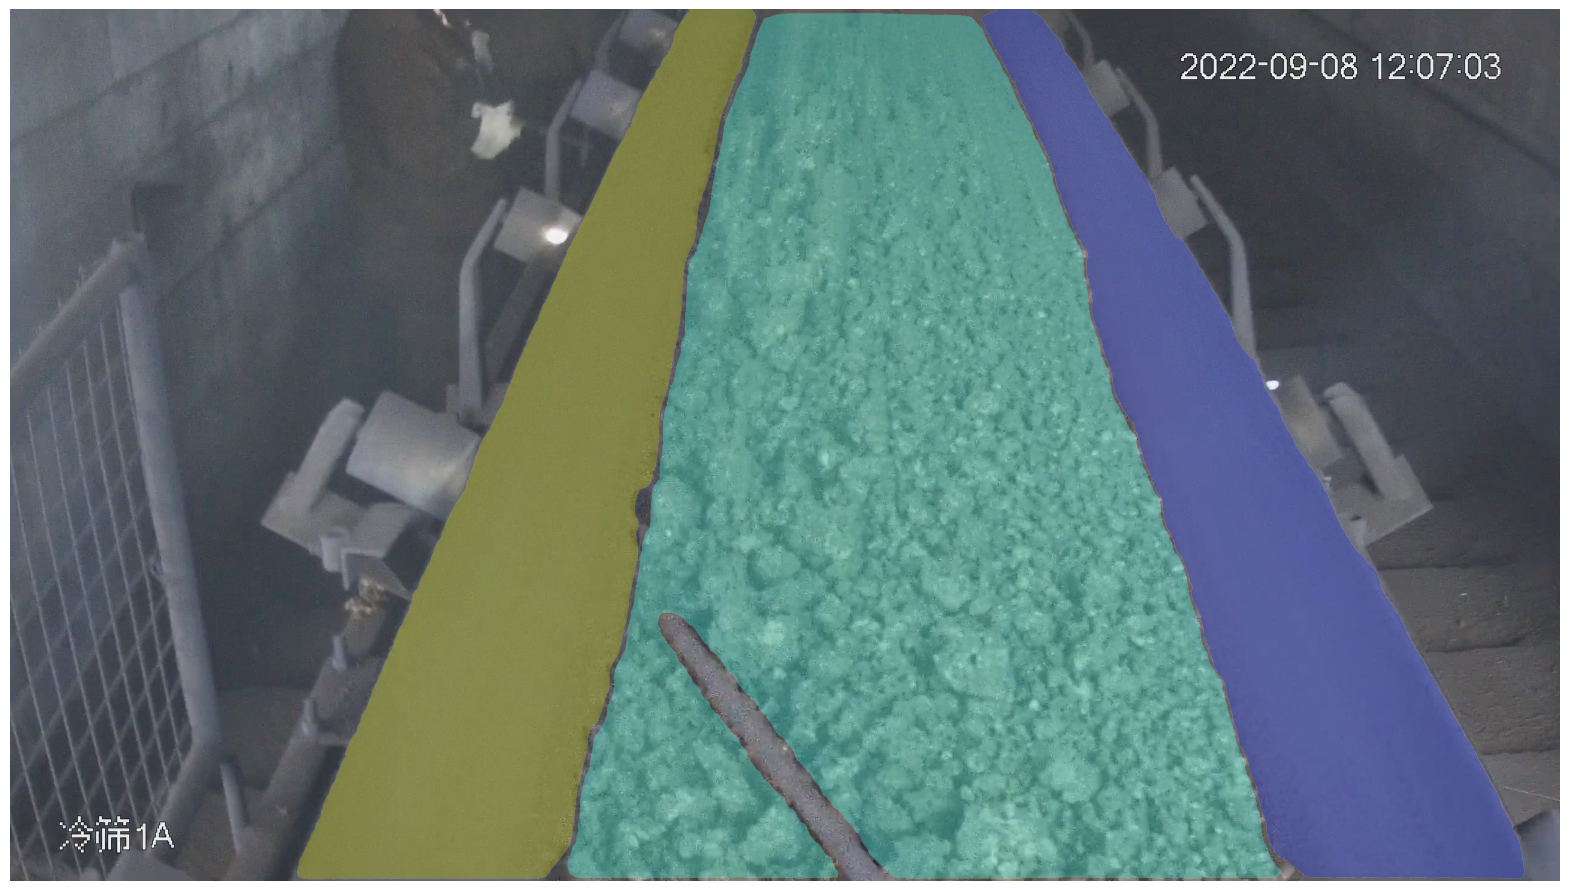

In [7]:
import cv2
import torch

torch.cuda.empty_cache()

image = cv2.imread(input_data[i][0])

masks = mask_generator.generate(image)

i += 1

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [8]:
res = get_anns(masks)
print(res[0]['bbox'])
print(res[1]['bbox'])
print(res[2]['bbox'])
print(res[3]['bbox'])

[921, 7, 1178, 1428]
[479, 0, 2021, 1436]
[474, 0, 757, 1436]
[1609, 0, 894, 1436]
